### Fine tuning the fine tune

This notebook will walk through the steps to customize the [stable-diffusion-inpainting](https://huggingface.co/runwayml/stable-diffusion-inpainting) model from runwayml.

In [1]:
!git clone https://github.com/lrav35/diffusion.git

Cloning into 'diffusion'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 129 (delta 3), reused 20 (delta 3), pack-reused 105
Receiving objects: 100% (129/129), 61.54 MiB | 12.00 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [2]:
!pip install -r diffusion/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.4/346.4 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
# !rm -rf diffusion

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import glob

In [7]:
def display_image_grid(images, size=256):
  grid_shape = (1,len(images))
  w, h = size, size
  rows, cols = grid_shape[0], grid_shape[1]
  grid = Image.new("RGB", size=(cols * w, rows * h))
  for i, image in enumerate(images):
    image = Image.open(image)
    image_resized = image.resize((size, size))
    grid.paste(image_resized, box=(i % cols * w, i // cols * h))
  return grid

First, we are going to teach our model about my cat, Stella! We will fine tune the inpainting model on six images of her and gain the ability to put her in different settings. Sure, stable diffusion could generate a cat, but it wouldn't be the real Stella. Let's see how this goes.

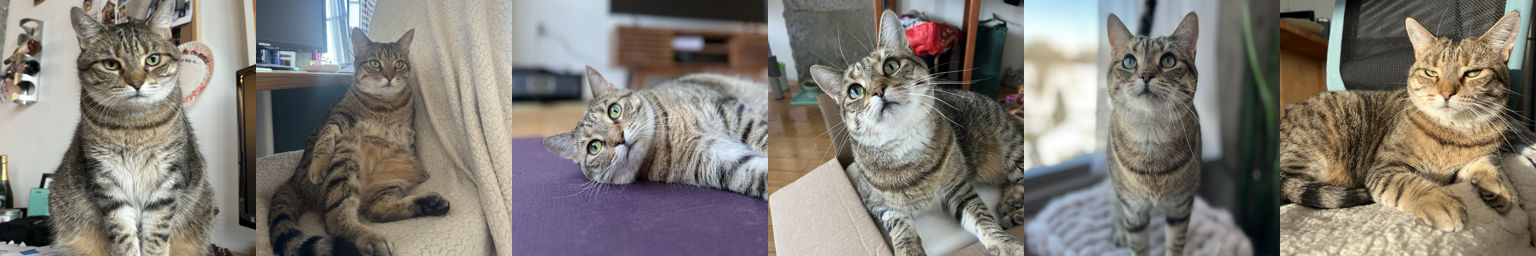

In [10]:
path = "diffusion/stella/*.JPEG"
images = [pth for pth in glob.glob(path)]

display_image_grid(images)

## Model Training

In [16]:
# !rm -rf /content/diffusion/stella/.ipynb_checkpoints

# !ls -a /content/diffusion/stella/

.  ..  IMG_0110.JPEG  IMG_5947.JPEG  IMG_6782.JPEG  IMG_8237.JPEG  IMG_8425.JPEG  IMG_8858.JPEG


In [ ]:
 # TODO: add wandb loss plot

In [17]:
!accelerate launch diffusion/fine_tune_dreambooth.py \
              --prompt="an image of my cat, Stella" \
              --input_data_dir="diffusion/stella" \
              --max_train_steps=500 \
              --train_batch_size=1

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2024-04-02 12:30:00.806470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 12:30:00.806527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 12:30:00.807969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alread

How did it work? Let's try some generations

In [18]:
from diffusers import StableDiffusionInpaintPipeline
import torch

# Load the pretrained model
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "diffusion-inpainting",
    torch_dtype=torch.float16
)
pipe.to('cuda')


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "diffusion-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

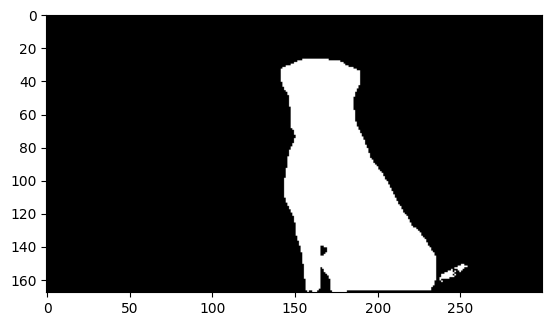

In [21]:
# get masks
import pickle
import matplotlib.pyplot as plt

with open('/content/diffusion/masks.pkl', 'rb') as f:
    mask_dict = pickle.load(f)

plt.imshow(mask_dict['rot'][2]['segmentation'], cmap='gray')
plt.show()

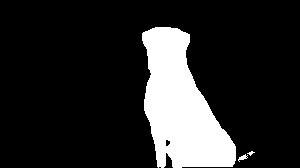

  0%|          | 0/50 [00:00<?, ?it/s]

AttributeError: read

In [26]:
image = Image.open("diffusion/dogs/rot.jpeg")
mask = Image.fromarray(mask_dict['rot'][2]['segmentation'])
display(mask)
images = pipe(prompt=["an image of my cat, Stella"]*4, image=image, mask_image=mask).images

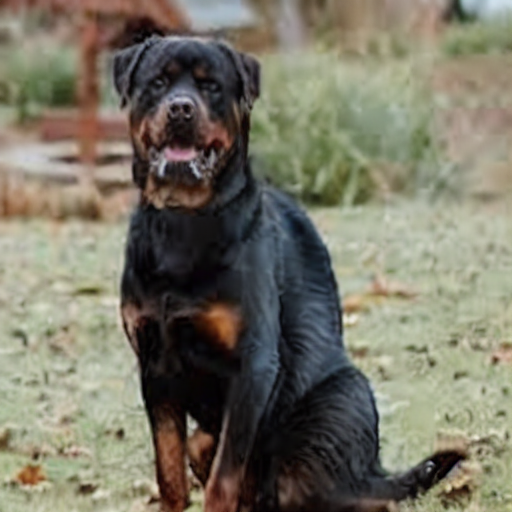

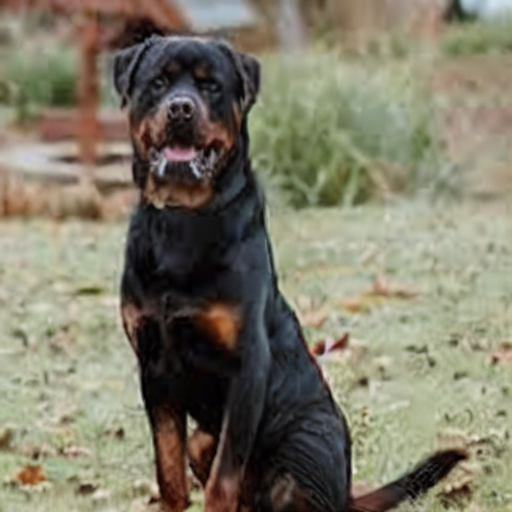

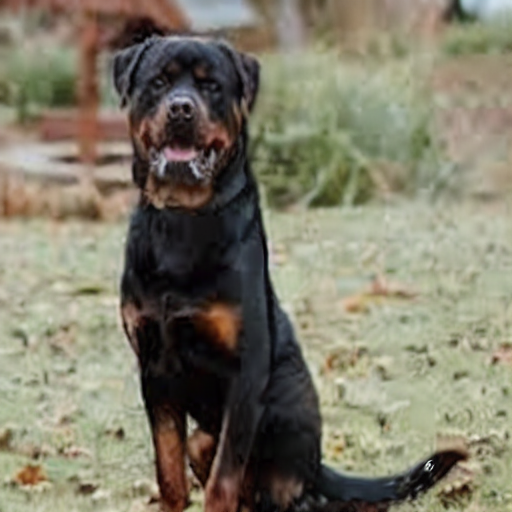

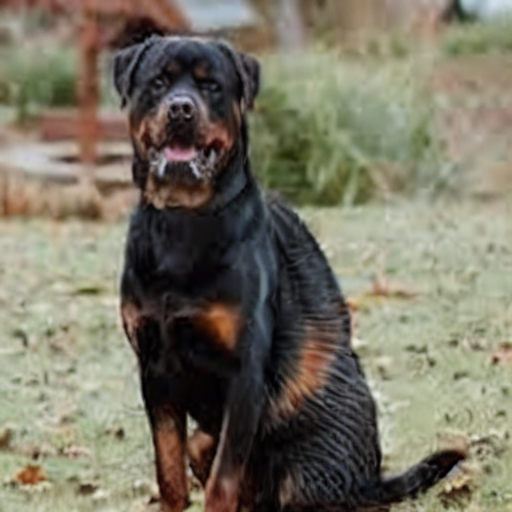

In [28]:
for i in images:
  display(i)

welp, that didnt really work. lets try using different images. you can kind of see it attempting to make the dog the same shape of a cat and adding a fur texture